## Introduction

A "point cloud" is an important type of data structure for storing geometric shape data.
Due to its irregular format, it's often transformed into
regular 3D voxel grids or collections of images before being used in deep learning applications,
a step which makes the data unnecessarily large.
The PointNet family of models solves this problem by directly consuming point clouds, respecting
the permutation-invariance property of the point data. The PointNet family of
models provides a simple, unified architecture
for applications ranging from **object classification**, **part segmentation**, to
**scene semantic parsing**.

Here, i have used the PointNet architecture
for shape segmentation.

### References

- [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593)
- [Point cloud classification with PointNet](https://keras.io/examples/vision/pointnet/)
- [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025)

## Imports

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Downloading Dataset

The [ShapeNet dataset](https://shapenet.org/) is an ongoing effort to establish a richly-annotated,
large-scale dataset of 3D shapes. **ShapeNetCore** is a subset of the full ShapeNet
dataset with clean single 3D models and manually verified category and alignment
annotations. It covers 55 common object categories, with about 51,300 unique 3D models.

For this project, i have used one of the 12 object categories of
[PASCAL 3D+](http://cvgl.stanford.edu/projects/pascal3d.html),
included as part of the ShapenetCore dataset.

In [2]:
dataset_url = "https://git.io/JiY4i"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

1078925405/1078925405 [==============================] - 32s 0us/step


## Loading the dataset

I have parsed the dataset metadata in order to easily map model categories to their
respective directories and segmentation classes to colors for the purpose of
visualization.

In [3]:
with open("/tmp/.keras/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

In this example, i have trained PointNet to segment the parts of an `Airplane` model.

In [4]:
points_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points".format(
    metadata["Airplane"]["directory"]
)
labels_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points_label".format(
    metadata["Airplane"]["directory"]
)
LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

## Structuring the dataset

I have generated the following in-memory data structures from the Airplane point clouds and
their labels:

- `point_clouds` is a list of `np.array` objects that represent the point cloud data in
the form of x, y and z coordinates. Axis 0 represents the number of points in the
point cloud, while axis 1 represents the coordinates. `all_labels` is the list
that represents the label of each coordinate as a string (needed mainly for
visualization purposes).
- `test_point_clouds` is in the same format as `point_clouds`, but doesn't have
corresponding the labels of the point clouds.
- `all_labels` is a list of `np.array` objects that represent the point cloud labels
for each coordinate, corresponding to the `point_clouds` list.
- `point_cloud_labels` is a list of `np.array` objects that represent the point cloud
labels for each coordinate in one-hot encoded form, corresponding to the `point_clouds`
list.

In [5]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))
for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        # Apply one-hot encoding to the dense label representation.
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)

100%|██████████| 4045/4045 [01:43<00:00, 39.01it/s]


Some samples from the in-memory arrays are:

In [6]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[3371].shape: (2632, 3)
point_cloud_labels[3371].shape: (2632, 5)
all_labels[3371][0]: none 	point_cloud_labels[3371][0]: [0. 0. 0. 0. 1.] 

all_labels[3371][1]: none 	point_cloud_labels[3371][1]: [0. 0. 0. 0. 1.] 

all_labels[3371][2]: body 	point_cloud_labels[3371][2]: [0. 1. 0. 0. 0.] 

all_labels[3371][3]: body 	point_cloud_labels[3371][3]: [0. 1. 0. 0. 0.] 

all_labels[3371][4]: none 	point_cloud_labels[3371][4]: [0. 0. 0. 0. 1.] 

point_clouds[2256].shape: (2632, 3)
point_cloud_labels[2256].shape: (2632, 5)
all_labels[2256][0]: wing 	point_cloud_labels[2256][0]: [1. 0. 0. 0. 0.] 

all_labels[2256][1]: wing 	point_cloud_labels[2256][1]: [1. 0. 0. 0. 0.] 

all_labels[2256][2]: body 	point_cloud_labels[2256][2]: [0. 1. 0. 0. 0.] 

all_labels[2256][3]: body 	point_cloud_labels[2256][3]: [0. 1. 0. 0. 0.] 

all_labels[2256][4]: body 	point_cloud_labels[2256][4]: [0. 1. 0. 0. 0.] 

point_clouds[3615].shape: (2632, 3)
point_cloud_labels[3615].shape: (2632, 5)
all_labels[3615]

Now,visualizing some of the point clouds along with their labels.

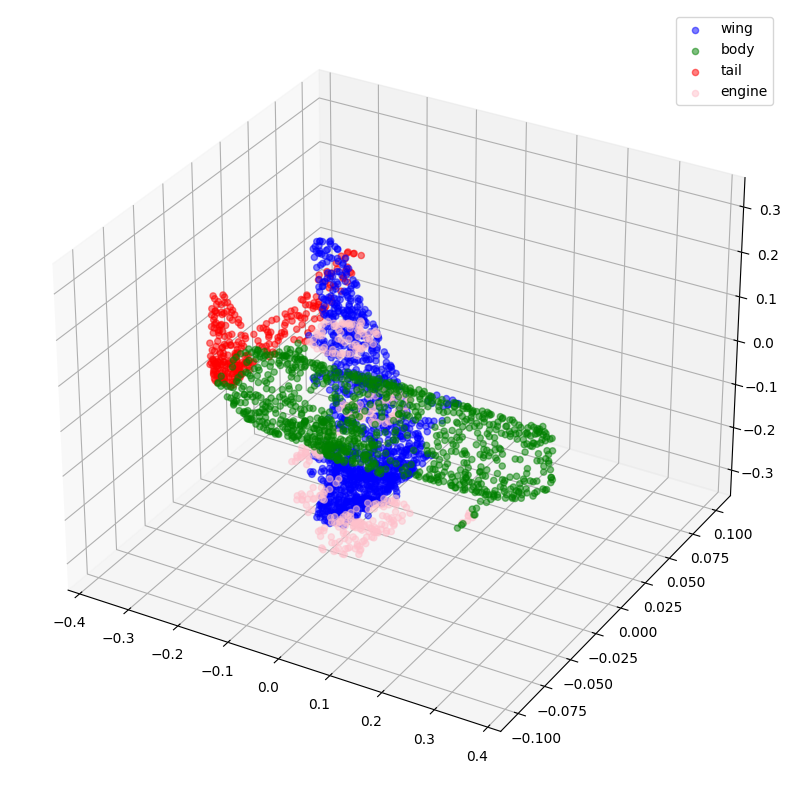

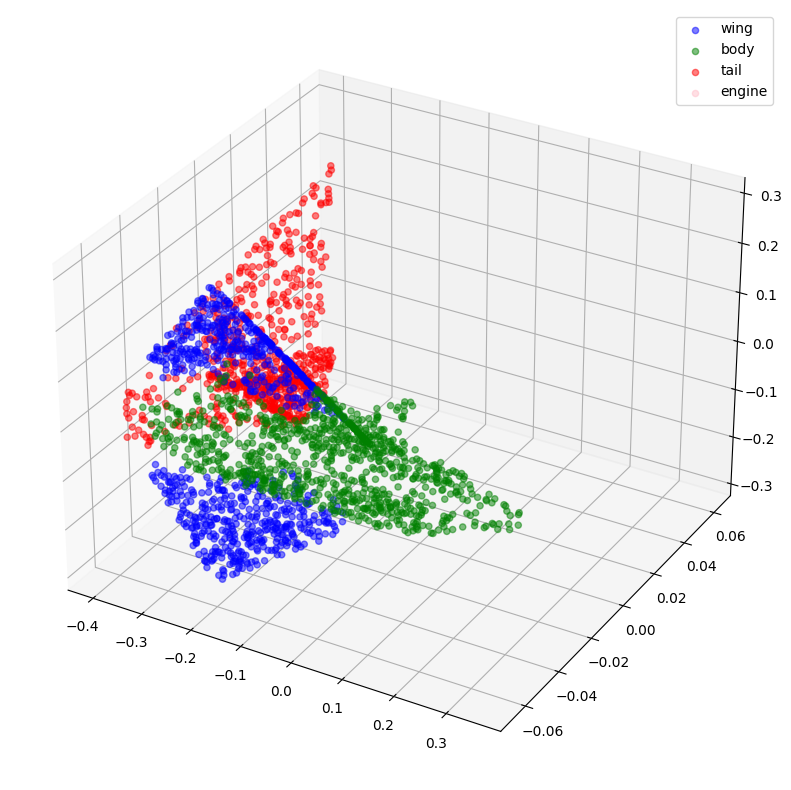

In [7]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

### Preprocessing



In [8]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 3694/3694 [00:09<00:00, 375.58it/s]


Visualizing the sampled and normalized point clouds along with their corresponding
labels.

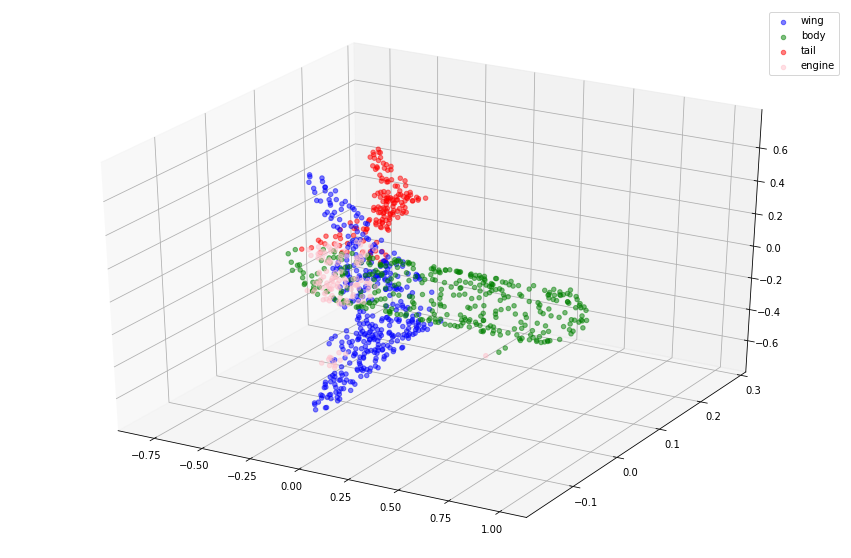

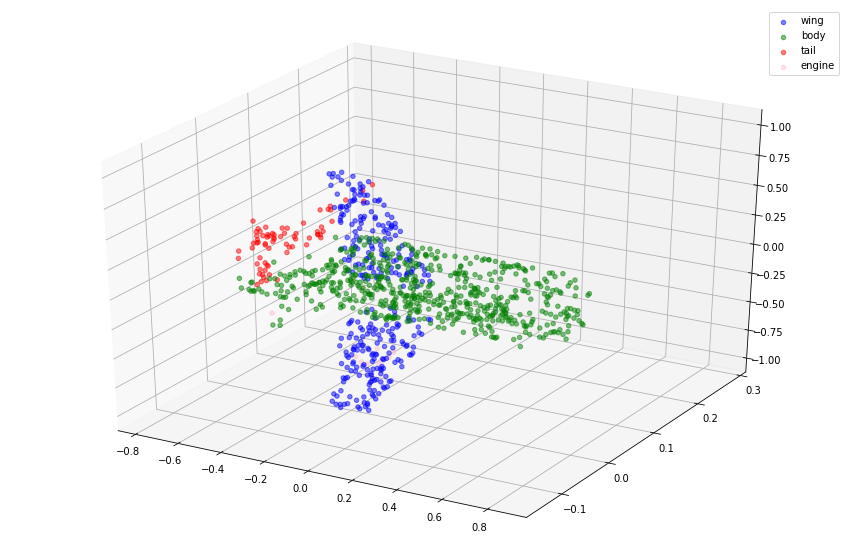

In [ ]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

### Creating TensorFlow datasets



In [9]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset


split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 2955
Num train point cloud labels: 2955
Num val point clouds: 739
Num val point cloud labels: 739
Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 5), dtype=tf.float32, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 5), dtype=tf.float32, name=None))>


Using PointNet model

In [10]:
def conv_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

Implemented a regularizer to enforce orthogonality in the feature space. This ensures that the magnitudes of the transformed features do not vary too much.

In [11]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config


Transformation network

In [12]:
def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [13]:
def get_shape_segmentation_model(num_points: int, num_classes: int) -> keras.Model:
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

## Instantiate the model

In [14]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 input_transformation_block  (None, None, 64)             256       ['input_1[0][0]']             
 _1_conv (Conv1D)                                                                                 
                                                                                                  
 input_transformation_block  (None, None, 64)             256       ['input_transformation_block_1
 _1_batch_norm (BatchNormal                                         _conv[0][0]']                 
 ization)                                                                                     

## Training



Total training steps: 5520.


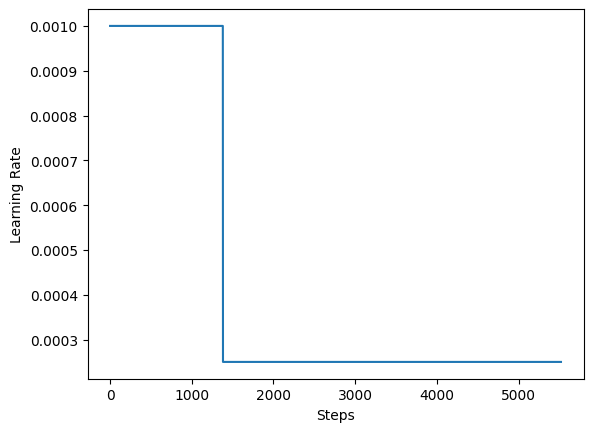

In [15]:
training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[training_step_size * 15, training_step_size * 15],
    values=[INITIAL_LR, INITIAL_LR * 0.5, INITIAL_LR * 0.25],
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

Finally, implemented a utility for running the experiments and launched model training.

In [16]:
def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/60
93/93 [==============================] - 60s 420ms/step - loss: 5.4169 - accuracy: 0.7274 - val_loss: 4.7391 - val_accuracy: 0.7993
Epoch 2/60
93/93 [==============================] - 35s 378ms/step - loss: 4.7103 - accuracy: 0.8157 - val_loss: 4.6468 - val_accuracy: 0.8149
Epoch 3/60
93/93 [==============================] - 35s 377ms/step - loss: 4.6728 - accuracy: 0.8244 - val_loss: 16.1771 - val_accuracy: 0.7289
Epoch 4/60
93/93 [==============================] - 35s 379ms/step - loss: 4.6470 - accuracy: 0.8305 - val_loss: 4.6045 - val_accuracy: 0.8287
Epoch 5/60
93/93 [==============================] - 35s 375ms/step - loss: 4.5979 - accuracy: 0.8389 - val_loss: 4.7612 - val_accuracy: 0.8059
Epoch 6/60
93/93 [==============================] - 35s 380ms/step - loss: 4.5972 - accuracy: 0.8392 - val_loss: 605.6340 - val_accuracy: 0.7532
Epoch 7/60
93/93 [==============================] - 35s 375ms/step - loss: 6.1274 - accuracy: 0.8137 - val_loss: 23.4922 - val_accuracy: 0.

## Visualize the training landscape

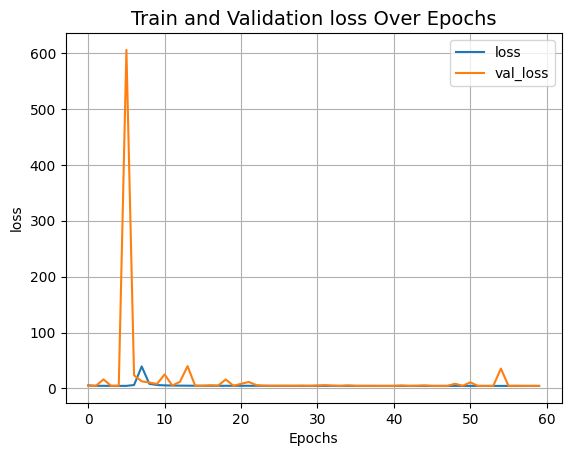

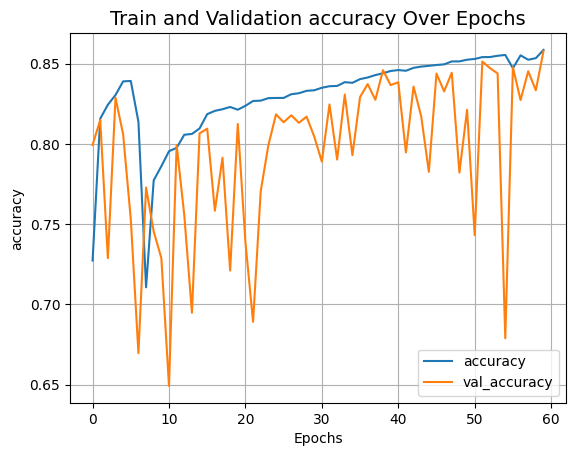

In [17]:

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

## Inference

1/1 [==============================] - 1s 804ms/step
Validation prediction shape: (32, 1024, 5)
Index selected: 18


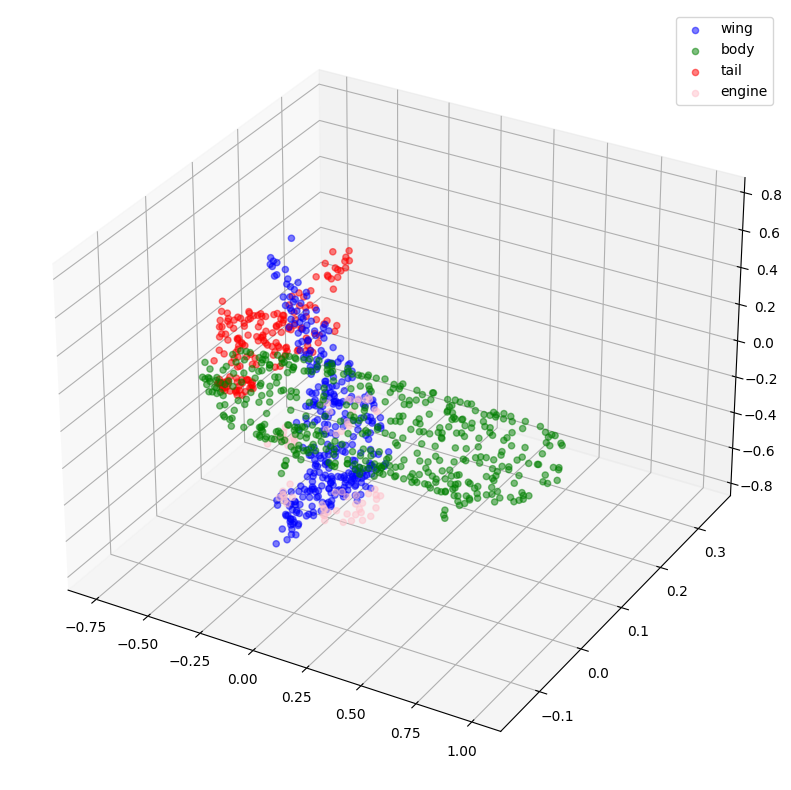

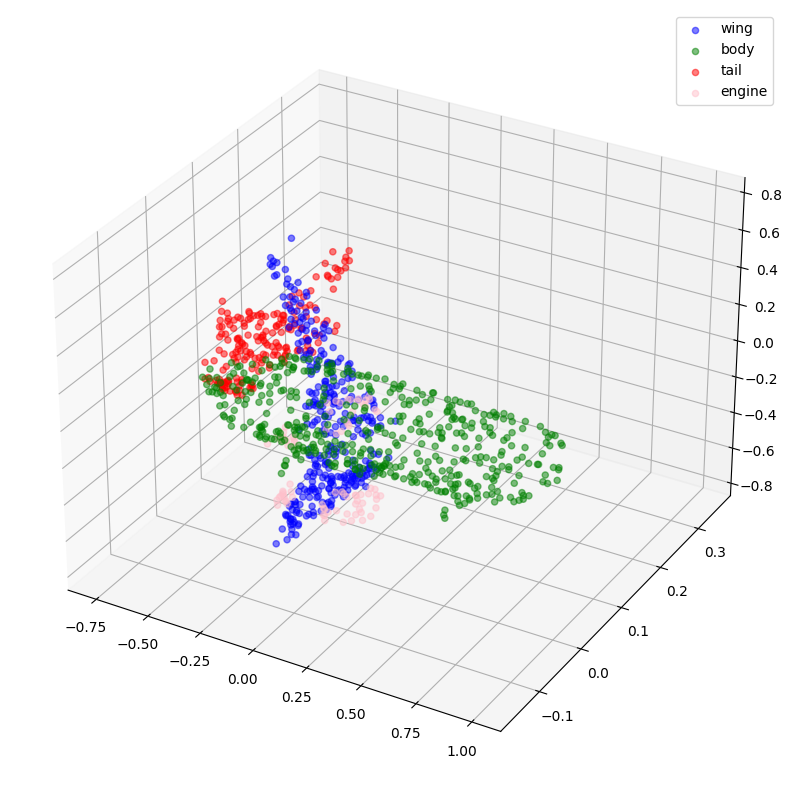

In [18]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)